# Import & setup

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from pathlib import Path
import gzip
from scipy.io import mmread

#set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

#defined paths
BASE_DIR = Path('/triumvirate/home/alexarol/breast_cancer_analysis')
DATA_DIR = BASE_DIR / 'data'
RAW_DIR = DATA_DIR / 'GSE161529_RAW'
RESULTS_DIR = BASE_DIR / 'results'

print(f'base directory: {BASE_DIR}')
print(f'data directory: {DATA_DIR}')
print(f'raw data directory: {RAW_DIR}')

base directory: /triumvirate/home/alexarol/breast_cancer_analysis
data directory: /triumvirate/home/alexarol/breast_cancer_analysis/data
raw data directory: /triumvirate/home/alexarol/breast_cancer_analysis/data/GSE161529_RAW


# Loading metadata and clasiffying samples

In [2]:
#loaded metadata
THEBIGBOSS = pd.read_csv(RESULTS_DIR / 'TheBigBoss.csv')

print(f'total samples: {len(THEBIGBOSS)}')
print(f'\\ncolumns: {list(THEBIGBOSS.columns)}')

total samples: 69
\ncolumns: ['GEO_ID', 'MatrixFile', 'BarcodesFile', 'SampleName', 'Title', 'CellNumAfter', 'GenesDetected']


In [3]:
#created function to automatically classify sample types
def classify_sample_type(title):
    '''
    classifies sample into biological category based on title
    
    parameters:
    -----------
    title : str
        sample title from metadata
        
    returns:
    --------
    str : sample category
    '''
    title_lower = title.lower()
    
    if 'normal' in title_lower:
        return 'Normal'
    elif 'brca1 pre-neoplastic' in title_lower:
        return 'BRCA1_PreNeoplastic'
    elif 'triple negative brca1' in title_lower:
        return 'TripleNegative_BRCA1'
    elif 'triple negative' in title_lower:
        return 'TripleNegative'
    elif 'her2+' in title_lower:
        return 'HER2_Positive'
    elif 'er+' in title_lower or 'pr+' in title_lower:
        return 'ER_Positive'
    else:
        return 'Unknown'

#applied classification
THEBIGBOSS['SampleType'] = THEBIGBOSS['Title'].apply(classify_sample_type)

#checked distribution
print('\\nsample type distribution:')
print(THEBIGBOSS['SampleType'].value_counts().sort_index())

\nsample type distribution:
SampleType
BRCA1_PreNeoplastic      4
ER_Positive             27
HER2_Positive            6
Normal                  24
TripleNegative           4
TripleNegative_BRCA1     4
Name: count, dtype: int64


**What am I doing here?**

Automatically categorizing each sample into its cancer subtype based on the title. This eliminates manual lookup.

**Output:**

Count of samples per category (Normal, BRCA1_PreNeoplastic, TripleNegative...)

**Why do I do this?**

I will compare networks across subtypes, so proper classification is critical.

In [4]:
#saved enhanced metadata
THEBIGBOSS.to_csv(RESULTS_DIR / 'TheBigBoss_enhanced.csv', index=False)
print(f'\\nenhanced metadata saved to: {RESULTS_DIR / "TheBigBoss_enhanced.csv"}')

\nenhanced metadata saved to: /triumvirate/home/alexarol/breast_cancer_analysis/results/TheBigBoss_enhanced.csv


# Helper: load_sample()

in this part i dont need to enter the sample name, this is a helper function -» it's designed to take a single row from THEBIGBOSS that describes one sample

In [5]:
def load_sample(sample_row, features_file=None):
    '''
    loads scRNA-seq data for a single sample
    
    parameters:
    -----------
    sample_row : pandas.Series
        row from THEBIGBOSS containing sample metadata
    features_file : Path, optional
        path to features file (default: DATA_DIR / 'GSE161529_features.tsv')
        
    returns:
    --------
    anndata.AnnData
        annotated data object with counts, cell barcodes, and gene features
        
    structure:
    ----------
    adata.X : count matrix (cells × genes)
    adata.obs : cell metadata (barcodes, sample info)
    adata.var : gene metadata (gene names, IDs)
    '''
    
    #set default features file if not provided
    if features_file is None:
        features_file = DATA_DIR / 'GSE161529_features.tsv'
    
    #extracted file paths from metadata row
    matrix_file = RAW_DIR / sample_row['MatrixFile']
    barcodes_file = RAW_DIR / sample_row['BarcodesFile']
    
    print(f'loading sample: {sample_row["SampleName"]}')
    print(f'  sample type: {sample_row["SampleType"]}')
    print(f'  expected cells: {sample_row["CellNumAfter"]}')
    
    #loaded matrix (genes × cells in MatrixMarket format)
    with gzip.open(matrix_file, 'rb') as f:
        matrix = mmread(f).T.tocsr()  #transposed to cells × genes
    
    #loaded barcodes (cell IDs)
    barcodes = pd.read_csv(barcodes_file, header=None, names=['barcode'])
    
    #loaded features (gene names)
    features = pd.read_csv(features_file, sep='\t', header=None, names=['gene_id', 'gene_name'])

    #verified dimensions match
    assert matrix.shape[0] == len(barcodes), 'matrix rows != barcode count'
    assert matrix.shape[1] == len(features), 'matrix columns != feature count'
    
    #created AnnData object
    adata = sc.AnnData(X=matrix, obs=barcodes, var=features)
    
    #added sample metadata to observations
    adata.obs['sample_name'] = sample_row['SampleName']
    adata.obs['sample_type'] = sample_row['SampleType']
    adata.obs['geo_id'] = sample_row['GEO_ID']
    
    print(f'  loaded: {adata.n_obs} cells × {adata.n_vars} genes')
    print(f'  total counts: {adata.X.sum():,.0f}')
    
    return adata

at this point i should have created the function and if i understand it right, this should not have any output so far, i just loaded the function `load_sample` into memory

and now i should be able to call this function to load actual data for sample

**What this function does:**
1. Takes one row from TheBigBoss.csv
2. Loads the corresponding matrix, barcodes, and features
3. Combines them into an AnnData object (standard format for scRNA-seq)
4. Adds sample metadata (name, type, GEO ID) to each cell

**Why AnnData:**
- Industry standard for single-cell analysis
- Integrates with Scanpy
- Stores counts, cell info, gene info together

**What i'll get back:**
- `adata.X`: Count matrix (cells × genes)
- `adata.obs`: Cell metadata (one row per cell)
- `adata.var`: Gene metadata (one row per gene)


# Helper: inspect_sample()

In [6]:
def inspect_sample(adata):
    '''
    prints summary statistics for loaded sample
    '''
    #calculated basic stats
    counts_per_cell = np.array(adata.X.sum(axis=1)).flatten()
    genes_per_cell = np.array((adata.X > 0).sum(axis=1)).flatten()
    sparsity = (1 - adata.X.nnz / (adata.n_obs * adata.n_vars)) * 100

    print('\n=== sample summary ===')
    print(f"sample name: {adata.obs['sample_name'].unique()[0]}")
    print(f"sample type: {adata.obs['sample_type'].unique()[0]}")
    print(f"dimensions: {adata.n_obs} cells × {adata.n_vars} genes")
    print(f"total UMI counts: {adata.X.sum():,.0f}")
    print(f"mean counts/cell: {counts_per_cell.mean():,.1f}")
    print(f"median counts/cell: {np.median(counts_per_cell):,.1f}")
    print(f"mean genes/cell: {genes_per_cell.mean():,.1f}")
    print(f"median genes/cell: {np.median(genes_per_cell):,.1f}")
    print(f"sparsity: {sparsity:.2f}%")
    print('\nfirst 3 cells:')
    print(adata.obs.head(3))
    print('\nfirst 3 genes:')
    print(adata.var.head(3))

    #printed summary string
    print(
        f"\nThis '{adata.obs['sample_type'].unique()[0]}' sample ('{adata.obs['sample_name'].unique()[0]}') "
        f"has {adata.n_obs:,} cells and {adata.n_vars:,} genes; median cell has "
        f"{int(np.median(counts_per_cell)):,} UMIs and {int(np.median(genes_per_cell)):,} genes detected. "
        f"Sparsity: {sparsity:.1f}%."
    )

**What this function does:**
- Provides a quick summary of sample statistics
- Shows dimensions, counts, sparsity
- Displays example cells and genes

**Why this matters:** Always verify data loaded correctly before proceeding.

# Test

i got an error first time because i did not consider that matrxices are sparse 

I needed convert results to NumPy arrays if you want to use numpy math and formatting

I had to improve the initial inspect_sample() function by replacing the calculations for mean/median counts and gene numbers per cell, as well as any sum(axis=1) 

In [7]:
#selected one normal sample for testing
test_sample = THEBIGBOSS[THEBIGBOSS['SampleType'] == 'Normal'].iloc[0]

print('testing data loading with:')
print(f'  GEO_ID: {test_sample["GEO_ID"]}')
print(f'  sample name: {test_sample["SampleName"]}')
print(f'  sample type: {test_sample["SampleType"]}')
print('\\n')

#loaded the test sample -» function loads the count matrix, barcodes and features for that sampl
adata_test = load_sample(test_sample)

#inspected the test sample -» function prints summary stats on the loaded data, including number of cells, genes, UMI counts, mean/median counts per cell, sparsity and previews of cell/gene metadata
inspect_sample(adata_test)


testing data loading with:
  GEO_ID: GSM4909253
  sample name: N-0092-total
  sample type: Normal
\n
loading sample: N-0092-total
  sample type: Normal
  expected cells: 4443
  loaded: 4966 cells × 33538 genes
  total counts: 45,162,311

=== sample summary ===
sample name: N-0092-total
sample type: Normal
dimensions: 4966 cells × 33538 genes
total UMI counts: 45,162,311
mean counts/cell: 9,094.3
median counts/cell: 5,141.0
mean genes/cell: 1,830.6
median genes/cell: 1,556.5
sparsity: 94.54%

first 3 cells:
              barcode   sample_name sample_type      geo_id
0  AAACCTGAGACTAGGC-1  N-0092-total      Normal  GSM4909253
1  AAACCTGAGGACAGAA-1  N-0092-total      Normal  GSM4909253
2  AAACCTGAGGATGTAT-1  N-0092-total      Normal  GSM4909253

first 3 genes:
                     gene_id        gene_name
ENSG00000243485  MIR1302-2HG  Gene Expression
ENSG00000237613      FAM138A  Gene Expression
ENSG00000186092        OR4F5  Gene Expression

This 'Normal' sample ('N-0092-total') has 4,966

/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## QC metrics for normal sample loaded arlier

In [8]:
#step 1: calculated per-cell qc metrics using adata_test

import numpy as np

adata_test.obs['n_counts'] = adata_test.X.sum(1).A1 if hasattr(adata_test.X, "A1") else adata_test.X.sum(1)
adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1).A1 if hasattr(adata_test.X, "A1") else (adata_test.X > 0).sum(1)
mito_genes = [g for g in adata_test.var_names if g.startswith("MT-")]
if mito_genes:
    adata_test.obs['pct_mito'] = (
        adata_test[:, mito_genes].X.sum(1).A1 / adata_test.obs['n_counts'] 
        if hasattr(adata_test.X, "A1") 
        else adata_test[:, mito_genes].X.sum(1) / adata_test.obs['n_counts']
    ) * 100

Why: Per-cell QC metrics help reveal which cells are low-quality, guiding filtering.


What data: Your loaded AnnData object (adata_test) with cell × gene counts.


Output: Adds columns to .obs for UMI count, gene count, and percent mitochondrial.


What will you do next: Visualize these metrics as histograms to guide filtering.

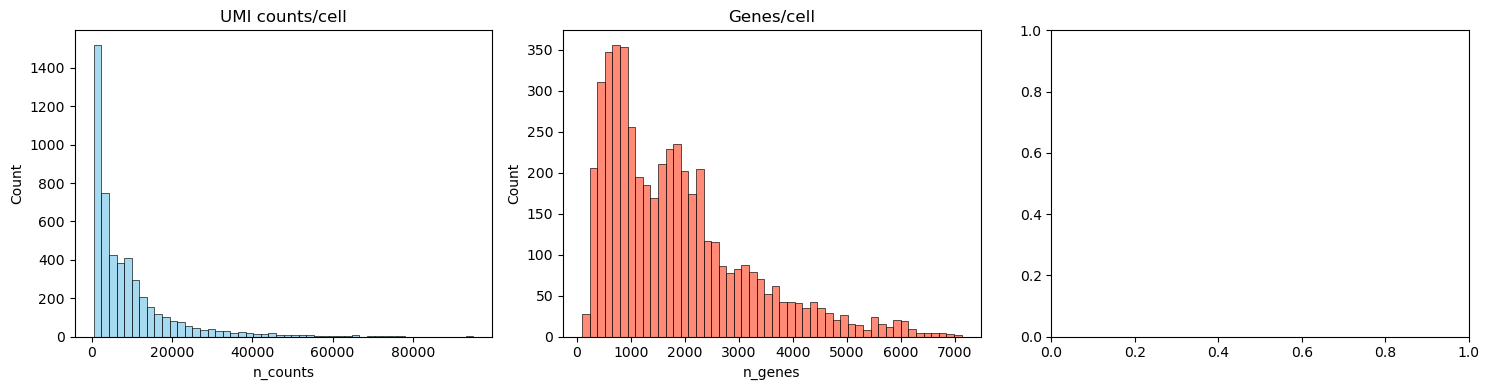

In [9]:
#step 2: visualized qc metrics distributions for adata_test

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(adata_test.obs["n_counts"], bins=50, ax=axs[0], color="skyblue"); axs[0].set_title("UMI counts/cell")
sns.histplot(adata_test.obs["n_genes"], bins=50, ax=axs[1], color="tomato"); axs[1].set_title("Genes/cell")
if "pct_mito" in adata_test.obs:
    sns.histplot(adata_test.obs["pct_mito"], bins=50, ax=axs[2], color="gray"); axs[2].set_title("Mito %/cell")
plt.tight_layout(); plt.show()

what do i see?

**UMI Counts/Cell**
- Sharp left spike: Huge number of cells with very low UMI counts (0–5,000 range).
- Long right tail: Some cells have 80,000+ UMIs (very high).
- Sign of empty droplets (dead cells, debris with few/no transcripts) mixed in with real cells. The spike suggests your sample wasn't pre-filtered well or the droplet quality was mixed.

**Genes/Cell**
- Peak around 800–1,200 genes per cell.
- Right tail: Some cells detect 5,000–7,000 genes (very high—could be doublets or high-complexity cells).
- Overall shape: More reasonable than UMI counts, but still bimodal (suggesting mixed populations).

**Mitochondrial %**
- Empty? Coudl suggest:
    - No mitochondrial genes annotated in your data (gene names don't start with "MT-"), OR
    - Mitochondrial content is negligible - IS THIS GOOD FOR HEALTHY CELLS?

**whats next?**
- filter out the low UMI spikes 
- i dont want to do it just blindly - i will look at quantiles and summary stats to decide thresholds
- i also want to make sure the mitochodrial genes do not exist

### setting cutoffs

In [10]:
#step 3: calculated summary statistics for cutoff decisions on adata_test

import pandas as pd

stats = pd.DataFrame({
    "n_counts": [
        adata_test.obs["n_counts"].min(),
        adata_test.obs["n_counts"].quantile(0.05),
        adata_test.obs["n_counts"].quantile(0.25),
        adata_test.obs["n_counts"].median(),
        adata_test.obs["n_counts"].quantile(0.75),
        adata_test.obs["n_counts"].quantile(0.95),
        adata_test.obs["n_counts"].max(),
    ],
    "n_genes": [
        adata_test.obs["n_genes"].min(),
        adata_test.obs["n_genes"].quantile(0.05),
        adata_test.obs["n_genes"].quantile(0.25),
        adata_test.obs["n_genes"].median(),
        adata_test.obs["n_genes"].quantile(0.75),
        adata_test.obs["n_genes"].quantile(0.95),
        adata_test.obs["n_genes"].max(),
    ]
}, index=["min", "5%", "25%", "median", "75%", "95%", "max"])

print(stats)

        n_counts  n_genes
min       502.00    99.00
5%        758.00   389.00
25%      2008.00   800.00
median   5141.00  1556.50
75%     11325.00  2408.75
95%     31603.75  4509.25
max     95035.00  7121.00


**Threshold	Reasoning**

- Min n_counts ≥ 1,000–1,500	Remove the left spike (empty droplets). Your 25% is 2,008; cutting at ~1,000 removes obvious debris.
- Min n_genes ≥ 300–500	Remove cells with extreme low complexity. Your 5% is 389; cutting here removes outliers.
- Max n_counts ≤ 50,000	Optional: remove potential doublets (two cells captured as one). Your 95% is 31,603; cutting at 50,000 is conservative.
- Max n_genes ≤ 6,000	Optional: remove extreme complexity. Your 95% is 4,509; cutting at 6,000 is very permissive.

In [11]:
#checked if mitochondrial genes exist in adata_test
mito_genes = [g for g in adata_test.var_names if g.startswith("MT-")]
print(f"mitochondrial genes found: {len(mito_genes)}")

mitochondrial genes found: 0


### filtering cells

In [12]:
#step 4: verified cell filtering code on a subset of adata_test

adata_subset = adata_test[:1000].copy()  #subsetting first 1000 cells for quick check

cell_mask = (adata_subset.obs['n_counts'] >= 2000) & (adata_subset.obs['n_genes'] >= 500)
adata_subset_filt = adata_subset[cell_mask].copy()

print(f"cells before filtering: {adata_subset.n_obs}, after filtering: {adata_subset_filt.n_obs}")

cells before filtering: 1000, after filtering: 757


In [13]:
#step 5: filtered low-quality cells from adata_test using moderate thresholds, saved as new object

cell_mask = (adata_test.obs['n_counts'] >= 2000) & (adata_test.obs['n_genes'] >= 500)
adata_filtered = adata_test[cell_mask].copy()

print(f"cells before filtering: {adata_test.n_obs}, after filtering: {adata_filtered.n_obs}")

#step 6: saved filtered adata as new file to preserve original
adata_filtered.write('adata_test_filtered.h5ad')  #change filename as needed

cells before filtering: 4966, after filtering: 3734


In [14]:
#step 7: documented number of cells and genes before/after filtering

print(f"original cells: {adata_test.n_obs}, filtered cells: {adata_filtered.n_obs}")
print(f"original genes: {adata_test.n_vars}, filtered genes: {adata_filtered.n_vars}")

original cells: 4966, filtered cells: 3734
original genes: 33538, filtered genes: 33538


**Cell filtering:**

started with 4,966 cells.

After filtering for moderate quality (n_counts ≥ 2,000, n_genes ≥ 500), 3,734 cells remain.

~75% retention

**Gene filtering:**

will do now

### filtering genes

In [15]:
#step 8: filtered rare genes from adata_filtered, saved as new object

import numpy as np

gene_mask = np.array((adata_filtered.X > 0).sum(axis=0)).flatten() >= 3  #kept genes detected in ≥3 cells
adata_filtered_genes = adata_filtered[:, gene_mask].copy()

print(f"genes before filtering: {adata_filtered.n_vars}, after filtering: {adata_filtered_genes.n_vars}")

#step 9: saved filtered object as new file (no overwrite)
adata_filtered_genes.write("adata_test_filtered_genes.h5ad")

genes before filtering: 33538, after filtering: 18958


**Output:**
- Variable adata_filtered_genes contains cells × filtered genes.
- File adata_test_filtered_genes.h5ad for full traceability.

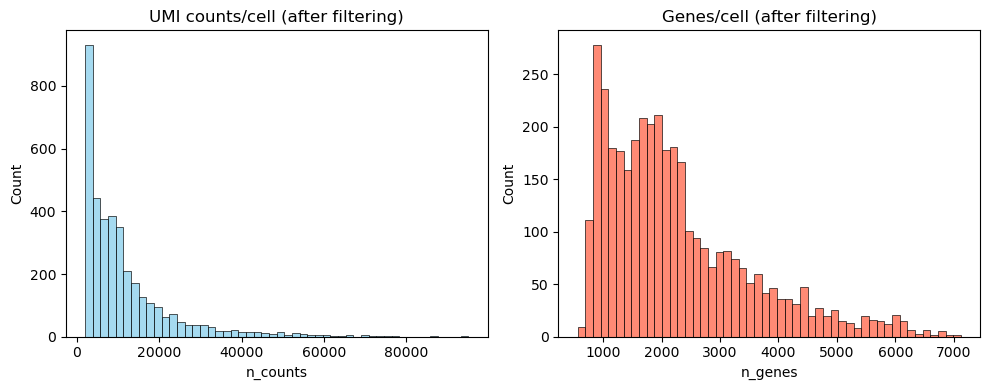

In [16]:
#step 9: visualized qc metric distributions after filtering in adata_filtered_genes

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(adata_filtered_genes.obs['n_counts'], bins=50, ax=axs[0], color='skyblue')
axs[0].set_title('UMI counts/cell (after filtering)')
sns.histplot(adata_filtered_genes.obs['n_genes'], bins=50, ax=axs[1], color='tomato')
axs[1].set_title('Genes/cell (after filtering)')
plt.tight_layout()
plt.show()

In [17]:
#step 10: tested normalization on subset of adata_filtered_genes

import scanpy as sc

adata_subset = adata_filtered_genes[:500].copy()   #subsetting first 500 cells

sc.pp.normalize_total(adata_subset, target_sum=1e4)   #normalized per cell to 10,000 counts
sc.pp.log1p(adata_subset)   #log(x+1) transformation

#checked sum of counts per cell
print(adata_subset.X.sum(axis=1).A1[:5] if hasattr(adata_subset.X, "A1") else adata_subset.X.sum(axis=1)[:5])

[[2283.3713]
 [2453.7266]
 [2823.1262]
 [2347.6816]
 [2371.7578]]


The code applied log(x+1) transformation after normalization.

Normalization (normalize_total) scales each cell so the raw sum equals 10,000.

Log-transform (log1p) compresses values, reducing the row sum—this is expected and correct.

Interpretation:

If you check the sum immediately after normalization, before log1p, it will be ~10,000 for each cell.

After log-transform, sum is lower, because log reduces every value.

In [18]:
#checked sum of counts per cell before and after log1p transformation

adata_subset = adata_filtered_genes[:5].copy()

sc.pp.normalize_total(adata_subset, target_sum=1e4)
print("sums after normalization, before log-transform:", adata_subset.X.sum(axis=1).A1 if hasattr(adata_subset.X, "A1") else adata_subset.X.sum(axis=1))

sc.pp.log1p(adata_subset)
print("sums after log-transform:", adata_subset.X.sum(axis=1).A1 if hasattr(adata_subset.X, "A1") else adata_subset.X.sum(axis=1))

sums after normalization, before log-transform: [[ 9999.999]
 [10000.001]
 [10000.   ]
 [ 9999.999]
 [10000.   ]]
sums after log-transform: [[2283.3713]
 [2453.7266]
 [2823.1262]
 [2347.6816]
 [2371.7578]]


In [19]:
#step 11: normalized and log-transformed adata_filtered_genes, created new object

adata_norm = adata_filtered_genes.copy()

sc.pp.normalize_total(adata_norm, target_sum=1e4)   #per-cell scaling (library size normalization)
sc.pp.log1p(adata_norm)   #log(x+1) transformation

#step 12: saved normalized object as a new file, preserved original data
adata_norm.write('adata_test_normalized.h5ad')

In [20]:
#step 13: attached and displayed sample metadata for traceability

adata_norm.uns['sample_name'] = test_sample['SampleName']
adata_norm.uns['geo_id'] = test_sample['GEO_ID']

print(f"analyzing sample: {adata_norm.uns['sample_name']} (GEO_ID: {adata_norm.uns['geo_id']})")

analyzing sample: N-0092-total (GEO_ID: GSM4909253)


### dimensionality reduction adn visualization

analyzing sample: N-0092-total (GEO_ID: GSM4909253)


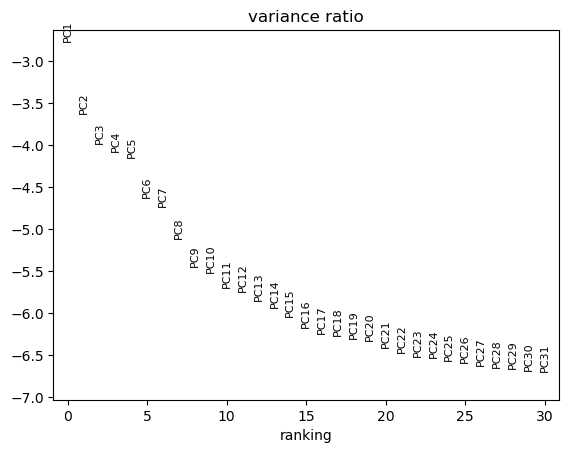

In [21]:
#step 14: performed PCA on normalized data

import scanpy as sc

print(f"analyzing sample: {adata_norm.uns['sample_name']} (GEO_ID: {adata_norm.uns['geo_id']})")
sc.pp.pca(adata_norm)
sc.pl.pca_variance_ratio(adata_norm, log=True)  #visualized explained variance

#step 15: saved PCA results as new file
adata_norm.write(f"{adata_norm.uns['sample_name']}_pca.h5ad")

**tryin to understand what is going on here**

- Plot showing, for each principal component (PC1, PC2, ... PC30), how much of the overall variation in data it explains.
- Each label (PC1, PC2, etc.) is a dimension in data that captures variation among cells.
**On the Y-axis:**
- Numbers (log-variance values, e.g., -3, -4, ...), not colors, dots, or cells.
- These are not cell data, just a summary: how much variation does each PC capture?

**Steep drop at first:**
- PC1 explains the most variation in your transcriptome profiles, followed by PC2.

**Long tail:**
- As you move to higher-number PCs (e.g., PC20+), they explain less biological signal and more noise.

In [22]:
#step 16: calculated cell neighbors and computed UMAP on pca space

print(f"analyzing sample: {adata_norm.uns['sample_name']} (GEO_ID: {adata_norm.uns['geo_id']})")

sc.pp.neighbors(adata_norm, n_neighbors=15, n_pcs=20)  #used first 20 principal components
sc.tl.umap(adata_norm)  #computed 2D embedding for visualization

analyzing sample: N-0092-total (GEO_ID: GSM4909253)


**Why:**
- Nearest-neighbor calculation finds which cells are most similar in reduced space.
- UMAP projects complex transcriptomic differences to 2D for interpretation.

**Data:**
- Normalized, PCA-reduced AnnData for selected sample.

**Output:**
- UMAP coordinates added to AnnData; not visualized yet.

analyzing sample: N-0092-total (GEO_ID: GSM4909253)


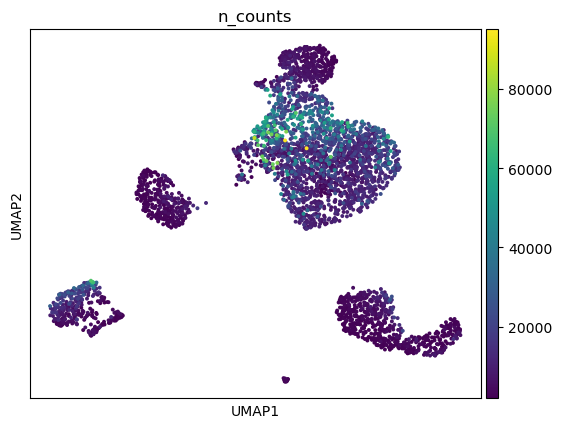

In [23]:
#step 17: visualized umap, colored by umi count to check quality patterns

print(f"analyzing sample: {adata_norm.uns['sample_name']} (GEO_ID: {adata_norm.uns['geo_id']})")

sc.pl.umap(adata_norm, color='n_counts')  #scatter of cells, color = total UMI per cell

**Why:**
- Reveals structure: clusters suggest distinct cell types, gradients continuous states.
- Coloring by UMI checks for technical (QC) effects driving separation.

**Data:**
- AnnData with UMAP embedding.

**Output:**
- 2D scatterplot: each point = a cell; clusters may represent different populations.

analyzing sample: N-0092-total (GEO_ID: GSM4909253)


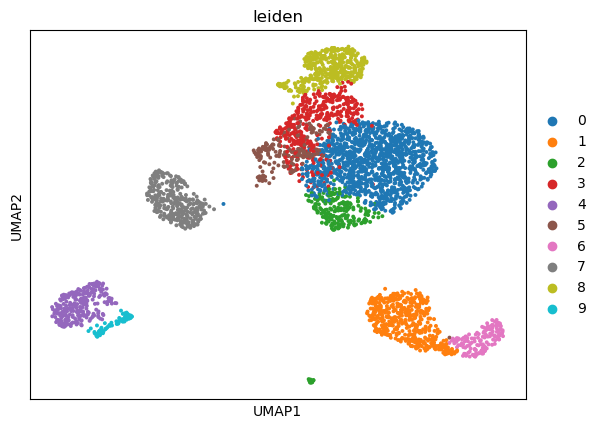

In [24]:
#step 18: clustered cells using leiden method

print(f"analyzing sample: {adata_norm.uns['sample_name']} (GEO_ID: {adata_norm.uns['geo_id']})")
sc.tl.leiden(
    adata_norm,
    resolution=0.5,
    flavor="igraph",         #used future default backend
    n_iterations=2,          #recommended for igraph
    directed=False           #required by igraph’s leiden implementation
)

#step 19: visualized umap colored by leiden clusters
sc.pl.umap(adata_norm, color='leiden')

#step 20: saved AnnData with cluster labels and embedding
adata_norm.write(f"{adata_norm.uns['sample_name']}_clusters.h5ad")

Each number (e.g., 0, 1, 2, …, 11) is a cluster ID assigned by the Leiden algorithm.

The algorithm groups similar cells (based on transcriptomic similarity in PCA space).

I have 12 clusters in your sample.

Each color represents a different cluster; cells with the same color/number are assigned to the same group.

Interpretation:

These groups should correspond to cell types, cell states or biological populations.

I don't know their biological meaning yet - next step

## marker gene discovery for cell annotation

analyzing sample: N-0092-total (GEO_ID: GSM4909253)


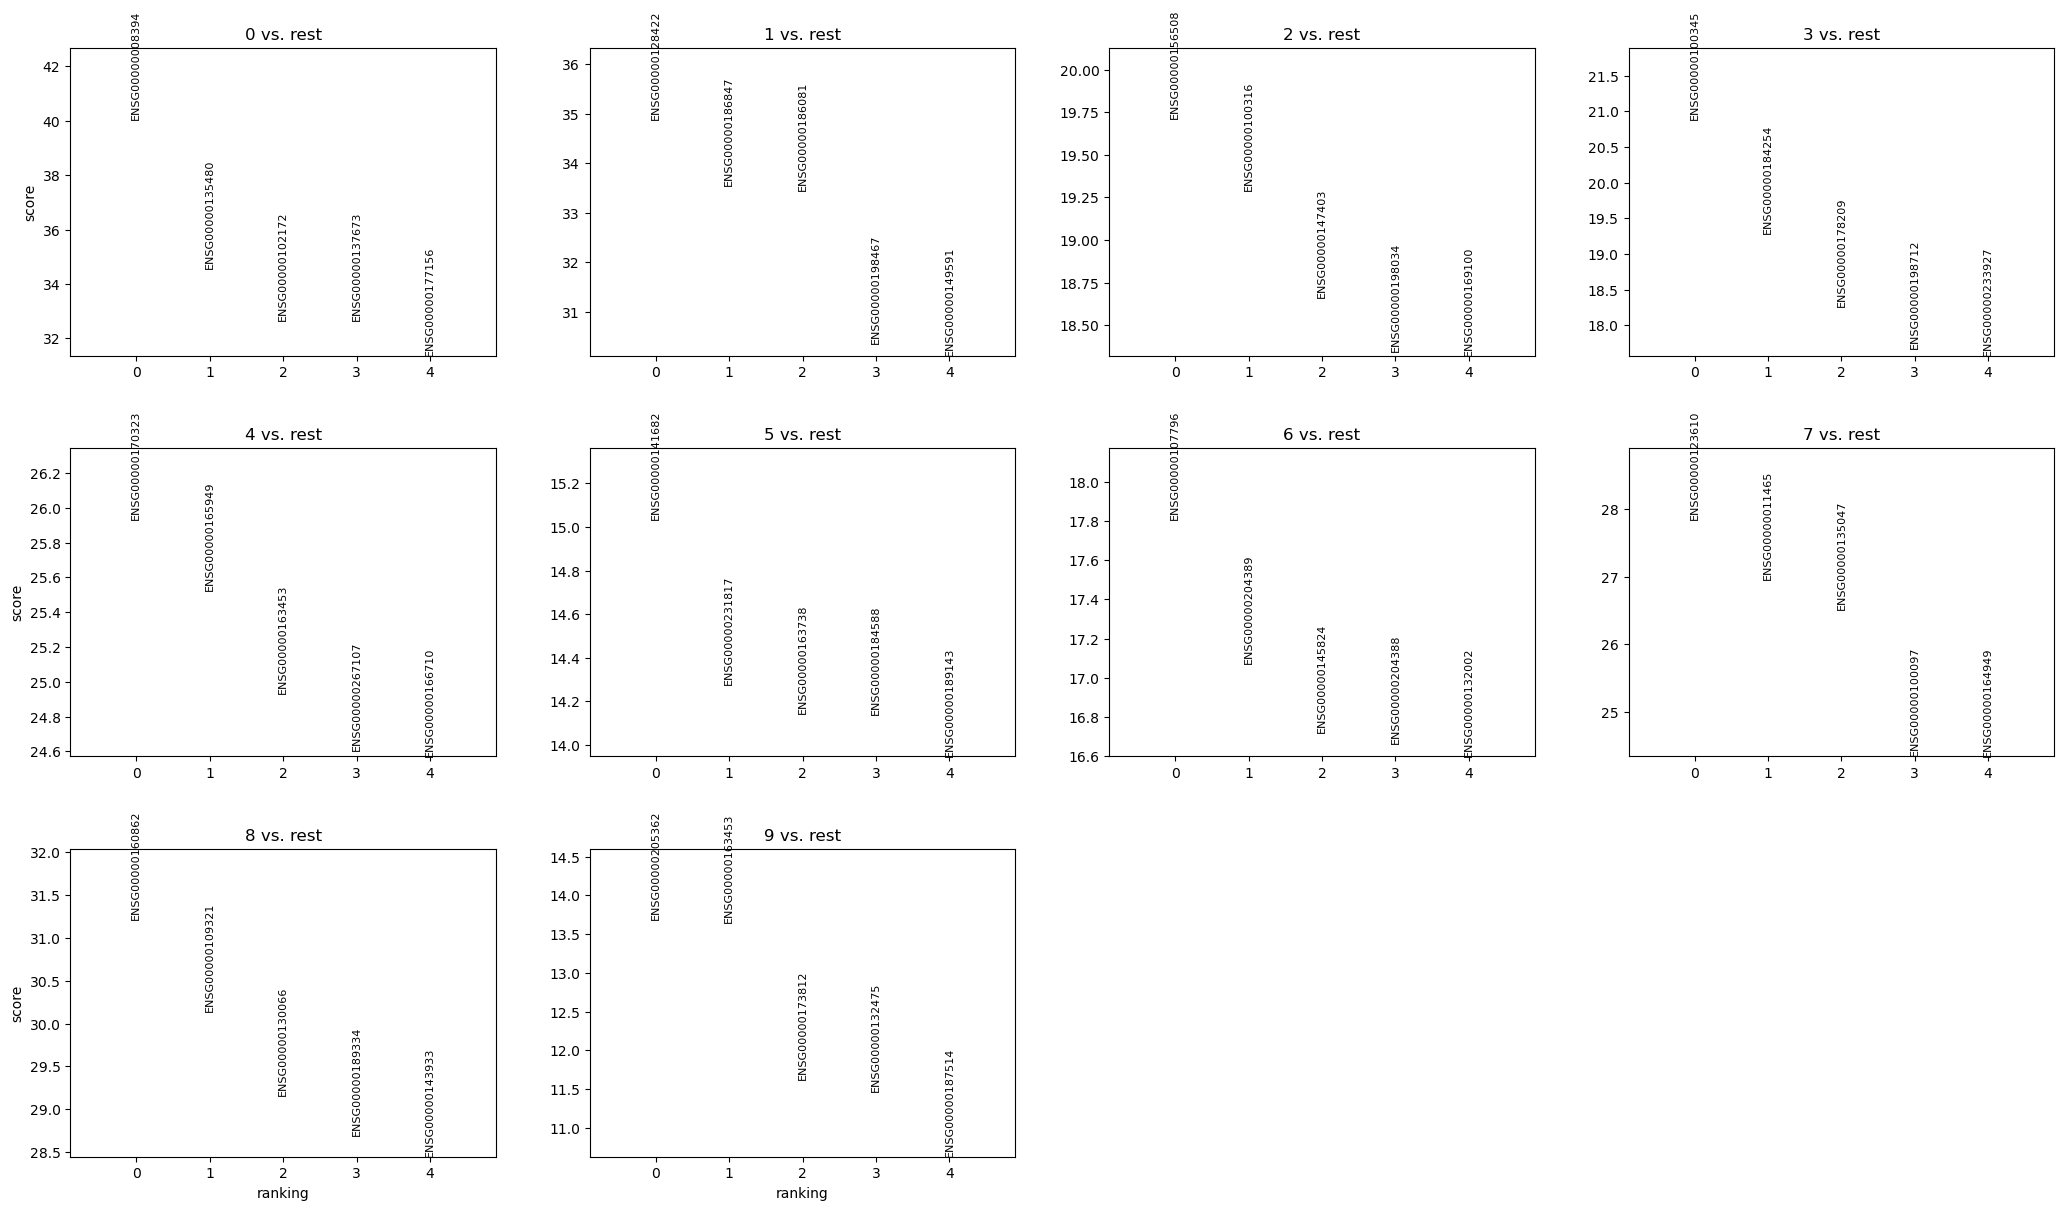

In [25]:
#step 21: identified marker genes for each leiden cluster

print(f"analyzing sample: {adata_norm.uns['sample_name']} (GEO_ID: {adata_norm.uns['geo_id']})")

sc.tl.rank_genes_groups(
    adata_norm,
    groupby='leiden',
    method='wilcoxon'
)

sc.pl.rank_genes_groups(adata_norm, n_genes=5, sharey=False)   #visualized top 5 marker genes per cluster

- Each subplot (e.g., 0 vs. rest, 1 vs. rest, ...) corresponds to one Leiden cluster from my data.
- Inside each subplot, i see the top 5 marker genes for that cluster. These are the genes most specifically enriched (highest “score”) in this cluster compared to all other cells.

**What’s shown:**
- Gene IDs - Ensembl IDs.
- need to map these using your gene annotation (I can guide this step if desired).
- Score axis: Indicates statistical strength of gene’s enrichment in that cluster

whats next?

**How to Use These Marker Genes**
- Identify Cell Types:
    - Marker genes let you infer the biological identity of each cluster (e.g., epithelial, immune, stromal, etc.).
    - You need to map those Ensembl IDs to gene names (e.g., EPCAM, CD3D, ACTB) for biological interpretation.
- Annotate Clusters:
    - Clusters with known marker genes for epithelial, immune, or stromal cells can be named accordingly.
    - The strength/specificity (score) can help decide how distinct/clean your clusters are.

In [26]:
#step 22: checked for gene symbols in annData

print(f"analyzing sample: {adata_norm.uns['sample_name']} (GEO_ID: {adata_norm.uns['geo_id']})")

#listed available columns in gene metadata
print(adata_norm.var.columns)

analyzing sample: N-0092-total (GEO_ID: GSM4909253)
Index(['gene_id', 'gene_name'], dtype='object')


In [27]:
#step 23: mapped ensembl gene ids to human-readable gene symbols

import pandas as pd

#extracted marker gene results
ranking = adata_norm.uns['rank_genes_groups']
groups = ranking['names'].dtype.names if hasattr(ranking['names'], "dtype") else ranking['names'].keys()

#created mapping of ids to symbols
gene_map = adata_norm.var['gene_name'].to_dict()

#created readable table for top marker genes
marker_table = {}
for group in groups:
    ids = ranking['names'][group][:5]  #top 5 marker genes for each cluster
    marker_table[group] = [gene_map.get(gid, gid) for gid in ids]

marker_df = pd.DataFrame(marker_table)
print(marker_df)

                 0                1                2                3  \
0  Gene Expression  Gene Expression  Gene Expression  Gene Expression   
1  Gene Expression  Gene Expression  Gene Expression  Gene Expression   
2  Gene Expression  Gene Expression  Gene Expression  Gene Expression   
3  Gene Expression  Gene Expression  Gene Expression  Gene Expression   
4  Gene Expression  Gene Expression  Gene Expression  Gene Expression   

                 4                5                6                7  \
0  Gene Expression  Gene Expression  Gene Expression  Gene Expression   
1  Gene Expression  Gene Expression  Gene Expression  Gene Expression   
2  Gene Expression  Gene Expression  Gene Expression  Gene Expression   
3  Gene Expression  Gene Expression  Gene Expression  Gene Expression   
4  Gene Expression  Gene Expression  Gene Expression  Gene Expression   

                 8                9  
0  Gene Expression  Gene Expression  
1  Gene Expression  Gene Expression  
2  Gene 

In [28]:
#step: inspected gene annotations in annData for debugging

print(adata_norm.var.head(10))

                    gene_id        gene_name
ENSG00000237491  AL669831.5  Gene Expression
ENSG00000225880   LINC00115  Gene Expression
ENSG00000230368      FAM41C  Gene Expression
ENSG00000230699  AL645608.3  Gene Expression
ENSG00000187634      SAMD11  Gene Expression
ENSG00000188976       NOC2L  Gene Expression
ENSG00000187961      KLHL17  Gene Expression
ENSG00000187583     PLEKHN1  Gene Expression
ENSG00000187642       PERM1  Gene Expression
ENSG00000272512  AL645608.8  Gene Expression


In [29]:
#step: inspected sample pairs of gene_map

gene_map = adata_norm.var['gene_name'].to_dict()
print(list(gene_map.items())[:10])

[('ENSG00000237491', 'Gene Expression'), ('ENSG00000225880', 'Gene Expression'), ('ENSG00000230368', 'Gene Expression'), ('ENSG00000230699', 'Gene Expression'), ('ENSG00000187634', 'Gene Expression'), ('ENSG00000188976', 'Gene Expression'), ('ENSG00000187961', 'Gene Expression'), ('ENSG00000187583', 'Gene Expression'), ('ENSG00000187642', 'Gene Expression'), ('ENSG00000272512', 'Gene Expression')]


In [30]:
#step 24: loaded correct feature table with headers externally for gene symbol extraction

import pandas as pd

features = pd.read_csv(
    '/triumvirate/home/alexarol/breast_cancer_analysis/data/GSE161529_features.tsv',
    sep='\t',
    header=None,
    names=['gene_id', 'gene_name', 'feature_type']
)

print(features.head())  #check correct loading and names

           gene_id    gene_name     feature_type
0  ENSG00000243485  MIR1302-2HG  Gene Expression
1  ENSG00000237613      FAM138A  Gene Expression
2  ENSG00000186092        OR4F5  Gene Expression
3  ENSG00000238009   AL627309.1  Gene Expression
4  ENSG00000239945   AL627309.3  Gene Expression


In [ ]:
#step 25: created dictionary mapping from gene_id to gene_name for later replacement

correct_gene_map = pd.Series(features['gene_name'].values, index=features['gene_id']).to_dict()

#example mapping check
example_id = list(correct_gene_map.keys())[0]
print(f'example mapping: {example_id} -> {correct_gene_map[example_id]}')

example mapping: ENSG00000243485 -> MIR1302-2HG


In [32]:
#step 26: replaced adata.var['gene_name'] with the correct symbols from external features

#note: index of adata.var should be gene_id (Ensembl IDs)
adata_norm.var['gene_name'] = adata_norm.var.index.map(correct_gene_map)

print(adata_norm.var[['gene_id', 'gene_name']].head(10))

                    gene_id   gene_name
ENSG00000237491  AL669831.5  AL669831.5
ENSG00000225880   LINC00115   LINC00115
ENSG00000230368      FAM41C      FAM41C
ENSG00000230699  AL645608.3  AL645608.3
ENSG00000187634      SAMD11      SAMD11
ENSG00000188976       NOC2L       NOC2L
ENSG00000187961      KLHL17      KLHL17
ENSG00000187583     PLEKHN1     PLEKHN1
ENSG00000187642       PERM1       PERM1
ENSG00000272512  AL645608.8  AL645608.8


noe the labeling is good, it si not geen expression but the exact name of the gene, i can proceed with further analysis of clustering

In [33]:
#step 27: mapped marker ensembl ids to gene symbols for clusters

import pandas as pd

ranking = adata_norm.uns['rank_genes_groups']
groups = ranking['names'].dtype.names if hasattr(ranking['names'], 'dtype') else ranking['names'].keys()

marker_table = {}
for group in groups:
    ids = ranking['names'][group][:5]                #top 5 marker Ensembl IDs for cluster
    symbols = [adata_norm.var['gene_name'].get(gid, gid) for gid in ids]  #map to gene symbols
    marker_table[group] = symbols

marker_df = pd.DataFrame(marker_table)
print(marker_df)

        0      1        2        3       4          5       6        7  \
0   MGST1  KRT17   EEF1A1     MYH9   FABP4     PMAIP1   ACTA2  TNFAIP6   
1    KRT7  KRT14     RPL3  ALDH1A3   IFI27  LINC01198  HSPA1A      DCN   
2     SMS   KRT5    RPL10     PLEC  IGFBP7    MTHFD2L  CXCL14     CTSL   
3    MMP7   TPM2    RPS4X   MT-CO2  PCAT19      PDE4B  HSPA1B   LGALS1   
4  TALDO1  TAGLN  SLC25A6    RPS28     B2M      CLDN4  DNAJB1      GEM   

         8       9  
0    AZGP1    MT1A  
1     AREG  IGFBP7  
2     SAT1    EIF1  
3  S100A14   H3F3B  
4    CALM2    PTMA  


Each cell of the table now displays a human-readable gene symbol rather than just an ID.

As for now, i would like to do a cell annotation. Based on th earticel I am working from and the github repo they provided this is what i have: 

Looking at their R code (specifically NormTotal.R):
- They load 10X data (raw counts, barcodes, features)
- They perform QC, normalization, clustering (just like you're doing!)
- They create Seurat objects with clusters
- They identify marker genes for each cluster
- They save everything as R objects (.rds, .RData)

**They have this line in R code:**

#load("../Data/Human-PosSigGenes.RData")

Basal <- intersect(Basal, y$genes$Official)

LP <- intersect(LP, y$genes$Official)

ML <- intersect(ML, y$genes$Official)

**And they save cell counts by cluster:**

write.csv(cellNum, file="NormTotalSub-CellCounts.csv")

The problem: Their cell type annotations are NOT exported as a simple barcode + celltype table. They're embedded in:

- Seurat objects (.rds files)
- R workspace files (.RData)

**Implicit in their cluster assignments (Cluster 1, 2, 3, etc. have biological meanings, but not explicitly labeled)**

They also have:
- ImmuneMarkers2.txt - List of immune cell markers (BCell, TCell genes)
- PAM50.txt - Gene signatures for Basal, LP, ML subtypes
- Human-PosSigGenes.RData - Gene signatures (need to read properly)
- NormEpiSub-CellCounts.csv - Epithelial cell counts per sample (tells us they have epithelial subset)
- NormTotalSub-CellCounts.csv - All cell counts, clusters 1-7 (tells us which clusters exist)
- Their R code - Exact methodology for clustering & annotation

What's Missing:
- A direct barcode→celltype mapping file

**What i will try to do next:** instead of trying to extract their annotations, I will use their published cluster definitions + marker genes to do my own annotation.

**Phase 1: Extract Gene Signatures from Their Files**
- Load ImmuneMarkers2.txt (immune cell markers)
- Load PAM50.txt (epithelial subtypes)
- Extract the Human-PosSigGenes.RData using Python/R

**Phase 2: Score Cells Using Their Signatures**

For each cell, score expression of:
- Epithelial markers (EPCAM, KRT19, etc.)
- Immune markers (CD3D, CD8A, etc.)
- Basal markers (from PAM50)
- Luminal markers (from PAM50)

Assign cell type based on highest score

**Phase 3: Compare to Their Clusters**

Validate that our epithelial cells match their clusters

**Phase 4: Automate Across All Samples**

Apply consistent annotation to all 52 samples